# Import Stuff & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
RESOLUTION = 64

In [5]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Lambda(lambda x: x / 255.),
    transforms.Resize((RESOLUTION, RESOLUTION))
])


# Utils

In [7]:
def plot_image_from_list(__images, __labels, __count):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        _img = __images[_i].to("cpu").numpy()
        plt.imshow(_img, cmap= "gray")
        plt.xlabel(__labels[_i])
    plt.show()

In [17]:
def plot_randomly_form_dataset(__dataset):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index][0]
        images.append(image.squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        

In [9]:
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label,datapath = __dataset[index][0]
        print(datapath)
        images.append(image.squeeze())
        result = model(image.unsqueeze(dim=0).to(device)).squeeze().cpu().argmax()
        
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        

# Dataset

In [10]:
DATA_SOURCE = {
    #For mini datadset(double slash ver)
    "Abuse": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Abuse",
    "Arrest": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Arrest",
    "Arson": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Arson",
    "Assault": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Assault",
    "Burglary": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Burglary",
    "Explosion": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Explosion",
    "Fighting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Fighting",   
    "RoadAccidents":"D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\RoadAccidents",
    "Robbery": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Robbery",
    "Shooting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Shooting",
    "Shoplifting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Shoplifting",
    "Stealing": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Stealing",
    "Vandalism": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Vandalism",
    "Normal": "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Normal"
    

}


In [11]:
import os

# 파일 경로를 설정합니다.
directory_path = "D:\\Anomaly-Detection-Dataset\\Miniset_for_test_1\\Abuse"

# 경로가 존재하는지 확인합니다.
if os.path.exists(directory_path):
    print("경로가 존재합니다.")
    # 디렉터리 내의 파일 목록을 출력합니다.
    print("디렉터리 내용:", os.listdir(directory_path))
else:
    print("지정된 경로를 찾을 수 없습니다.")


경로가 존재합니다.
디렉터리 내용: ['Abuse001_x264.mp4', 'Abuse002_x264.mp4', 'Abuse003_x264.mp4', 'Abuse004_x264.mp4', 'Abuse005_x264.mp4', 'Abuse006_x264.mp4', 'Abuse007_x264.mp4', 'Abuse008_x264.mp4', 'Abuse009_x264.mp4', 'Abuse010_x264.mp4']


In [12]:
class CrimeDataset(Dataset):
    def __init__(self, __train=True, __train_test_split=0.95, __random_state=42):
        torch.manual_seed(__random_state)
        
        self._data = []
        self._labels = []
        self._inclusion_probability = __train_test_split if __train else 1.0 - __train_test_split
        self._frame_interval = 30
        
        print(f"Loading {'train' if __train else 'test' } dataset...")
        for label, data_path in DATA_SOURCE.items():
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):
                if file.endswith(".mp4") and torch.rand(1).item() <= self._inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)
                    # print(data)
                    # print(labels)
                    # print(data[0].shape)
                    # print(len(data))
                    # print(len(labels))
                    
                    
                    
                    self._data.extend(data)
                    self._labels.extend(labels)
        print(f"Finished loading {'train' if __train else 'test' } dataset... Loaded  {len(self._data)} images.")
    
    def _parse_file(self, __path, __label):
        if not os.path.exists(__path):
            return [], []
        
        data = []
        labels = []
        
        cap = cv2.VideoCapture(__path)
        
        frames = []
        success, image = cap.read()
        while success:
            try:
                if True:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    Y, U, V = cv2.split(image)
                    image = transformer(Y)
                    frames.append(image)
                    if len(frames) == 5:
                        stacked_frames = torch.stack(frames).unsqueeze(1)
                        data.append(stacked_frames)
                        labels.append(__label)
                        frames = []
            except Exception as e:
                print(f"Error loading file {__path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()
                count += 1
                
        if len(frames) > 0 and len(frames) < 5:
            while len(frames) < 5:
                frames.append(frames[-1])
            stacked_frames = torch.stack(frames).unsqueeze(1)
            data.append(stacked_frames)
            labels.append(__label)        
                
        return data, labels
        
    
    def label_str2id(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(__label)

    def label_id2str(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels)[__label]
        
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, __idx):
        data = self._data[__idx]
        label = self._labels[__idx]
        return data, torch.tensor([self.label_str2id(label)])

In [13]:
train_dataset = CrimeDataset(True)
test_dataset = CrimeDataset(False)

Loading train dataset...
Loading Label Abuse...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Loading Label Arrest...


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Loading Label Arson...


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


Loading Label Assault...


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Loading Label Burglary...


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Loading Label Explosion...


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Loading Label Fighting...


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


Loading Label RoadAccidents...


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Loading Label Robbery...


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Loading Label Shooting...


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Loading Label Shoplifting...


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


Loading Label Stealing...


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Loading Label Vandalism...


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Loading Label Normal...


100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Finished loading train dataset... Loaded  3093 images.
Loading test dataset...
Loading Label Abuse...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Arrest...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Arson...


100%|██████████| 9/9 [00:00<?, ?it/s]


Loading Label Assault...


100%|██████████| 10/10 [00:00<00:00, 23.31it/s]


Loading Label Burglary...


100%|██████████| 10/10 [00:00<00:00, 9950.90it/s]


Loading Label Explosion...


100%|██████████| 10/10 [00:00<00:00, 17.40it/s]


Loading Label Fighting...


100%|██████████| 9/9 [00:00<00:00, 8966.45it/s]


Loading Label RoadAccidents...


100%|██████████| 10/10 [00:00<00:00, 50.74it/s]


Loading Label Robbery...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Shooting...


100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]


Loading Label Shoplifting...


100%|██████████| 9/9 [00:01<00:00,  5.39it/s]


Loading Label Stealing...


100%|██████████| 10/10 [00:00<00:00, 37.65it/s]


Loading Label Vandalism...


100%|██████████| 10/10 [00:00<?, ?it/s]


Loading Label Normal...


100%|██████████| 12/12 [00:00<00:00, 27.20it/s]

Finished loading test dataset... Loaded  153 images.


In [18]:
plot_randomly_form_dataset(test_dataset)

ValueError: too many values to unpack (expected 2)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
print(len(train_loader))
print(len(train_loader.dataset))
data, target = next(iter(train_loader))
print(data.shape)
print(target.shape)

97
3093
torch.Size([32, 5, 1, 1, 64, 64])
torch.Size([32, 1])


# Model

In [21]:
class CrimeModelCNN(nn.Module):
    def __init__(self):
        super(CrimeModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding="same")
        self.ReLU = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding="same")
        self.max_pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16384, 256)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.dropout4(x)
        return x
    
    # leaky ReLU
    # def __init__(self):
    #     super(CrimeModelCNN, self).__init__()
    #     self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding="same")
    #     self.leaky_relu = nn.LeakyReLU(0.1)
    #     self.max_pool1 = nn.MaxPool2d(2, 2)
    #     self.dropout1 = nn.Dropout(0.25)
    #     self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
    #     self.max_pool2 = nn.MaxPool2d(2, 2)
    #     self.dropout2 = nn.Dropout(0.25)
    #     self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding="same")
    #     self.max_pool3 = nn.MaxPool2d(2, 2)
    #     self.dropout3 = nn.Dropout(0.4)
    #     self.flatten = nn.Flatten()
    #     self.fc1 = nn.Linear(16384, 256)
    #     self.dropout4 = nn.Dropout(0.5)

    # def forward(self, x):
    #     x = self.conv1(x)
    #     x = self.leaky_relu(x)
    #     x = self.max_pool1(x)
    #     x = self.dropout1(x)
    #     x = self.conv2(x)
    #     x = self.leaky_relu(x)
    #     x = self.max_pool2(x)
    #     x = self.dropout2(x)
    #     x = self.conv3(x)
    #     x = self.leaky_relu(x)
    #     x = self.max_pool3(x)
    #     x = self.dropout3(x)
    #     x = self.flatten(x)
    #     x = self.fc1(x)
    #     x = self.leaky_relu(x)
    #     x = self.dropout4(x)
    #     return x    

In [22]:
class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [23]:
# Only CNN
class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.cnn = CrimeModelCNN()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(256, 14)  # Adjust the input size according to your concatenation axis

    def forward(self, x):
        # x_cnn = x
        # x_lstm = torch.reshape(x, (x.shape[0], RESOLUTION * RESOLUTION, 1))
        x_cnn = self.cnn(x)
        # x_lstm = self.lstm(x_lstm)
        # x_combined = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.fc(x_cnn)
#         return F.softmax(x, dim=1)
        return x

In [24]:
model = CrimeModel()

In [25]:
print(model(torch.rand(64, 1, 64, 64)).shape)

torch.Size([64, 14])


# Training

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [27]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CrimeModel(
    (cnn): CrimeModelCNN(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (ReLU): ReLU()
      (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout2): Dropout(p=0.25, inplace=False)
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout3): Dropout(p=0.4, inplace=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=16384, out_features=256, bias=True)
      (dropout4): Dropout(p=0.5, inplace=False)
    )
    (lstm): CrimeModelLSTM(
      (lstm1): LSTM(1, 8, batch_first=True)
    

In [28]:
NUM_EPOCHS = 5

In [29]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

In [30]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  17849 KiB |  17851 KiB |  17858 KiB |   9728 B   |\n|       from large pool |  17536 KiB |  17536 KiB |  17536 KiB |      0 B   |\n|       from small pool |    313 KiB |    315 KiB |    322 KiB |   9728 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |  17849 KiB |  17851 KiB |  17858 KiB |   9728 B   |\n|       from large pool |  17536 KiB |  17536 KiB |

In [31]:
total_batches = len(train_loader)
for epoch in range(NUM_EPOCHS):
    model.train()
    _total_correct = 0
    
    print(f"Epoch : {epoch}...")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"Batch : {batch_idx + 1}/{total_batches}\t\t", end="\r")
        
        data = data.to(device)
        label = label.to(device)
        
        preds = model(data)
        
        # print(preds.shape, label.shape)
        # print(label)
        
        loss = criterion(preds, label.squeeze())
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{total_batches}")

Epoch : 0...


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 5, 1, 1, 64, 64]

In [ ]:
torch.save(model, "model.pt")

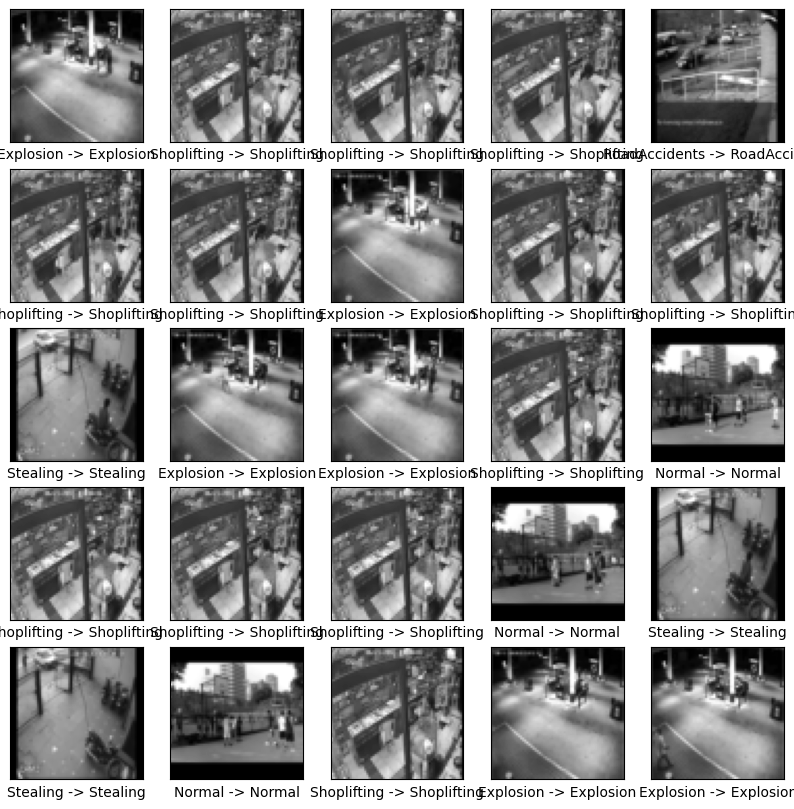

In [ ]:
plot_randomly_form_dataset_model(test_dataset, model)

In [ ]:
print(os.getcwd())

d:\urp_src
